<a href="https://colab.research.google.com/github/Ayoubsandali/Deep-Dream-/blob/main/deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-load image 
2- prepare image 
3-Load the model
4-loss calculation
5-gradiant ascent

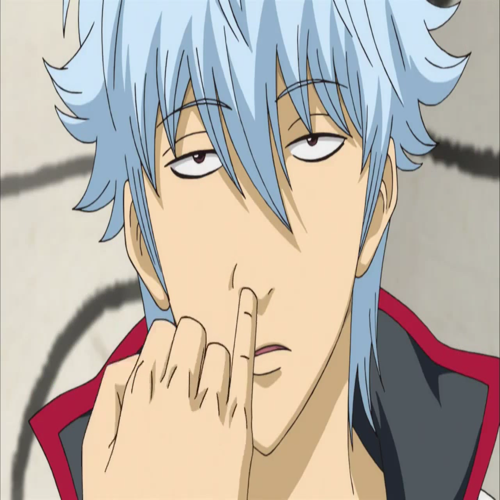

In [ ]:
import IPython.display as display
from PIL import Image
import numpy as np
import tensorflow as tf
#from tensorflow.keras.preprocessing import image


img_url= "/content/Capture d’écran (8).png"
img=Image.open(img_url).convert('RGB').resize((500,500))
img_to_array = np.array(img).astype('float32')


display.display(Image.fromarray(img_to_array.astype('uint8'), 'RGB').convert('RGB'))

def normalize(imgarray):
 
    for i in range(0,3):
        min_pixel = imgarray[...,i].min()
        max_pixel = imgarray[...,i].max()
        
        if min_pixel != max_pixel:
            imgarray[...,i]=255*(imgarray[...,i]-min_pixel)/(max_pixel-min_pixel)
               
    return imgarray
    
    


  


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
names = ['mixed3', 'mixed5','mixed9']
layers = [base_model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
def calc_loss(img, model):
  
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [ ]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
              
                tape.watch(img)
                loss = calc_loss(img, self.model)

            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:

    if steps_remaining>100:
        run_steps = tf.constant(100)
    else:
        run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps
    

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    display.clear_output(wait=True)
    print ("Step {}, loss {}".format(step, loss))


    

  return img

In [ ]:
import time
start = time.time()

octave_scale = 1.30
num_octave=3
original_shape = img_to_array.shape[1:3] 
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
  successive_shapes = successive_shapes[::-1]
successive_shapes = successive_shapes[::-1]

original_img = tf.constant(img_to_array)
img=tf.constant(img_to_array)
shrunk_original_img = tf.image.resize(img_to_array, successive_shapes[0])

for shape in successive_shapes:
  print('Processing image shape', shape)
  img= tf.image.resize(img, shape)
  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)



end = time.time()
end-start

dream_image=normalize(img)
display.display(Image.fromarray(dream_image.astype('uint8')).convert('RGB'))





Processing image shape (384, 2)


InvalidArgumentError: ignored

In [ ]:
dream_img_array = run_deep_dream_simple(img=img_to_array,steps=1000,step_size=0.01).numpy()


Step 1000, loss 3.109518051147461


In [ ]:
dream_image=normalize(dream_img_array)


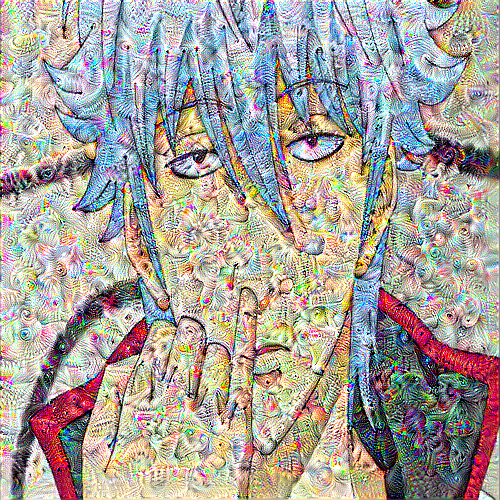

In [ ]:
display.display(Image.fromarray(dream_image.astype('uint8')).convert('RGB'))